In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [14]:
# Runs to compare
df_ppo = pd.read_csv('Data/2024-12-17_environment_data_PPO.csv')
df_ddpg = pd.read_csv('Data/2024-12-04_environment_data_ddpg.csv')
df_heuristic = pd.read_csv('Data/2024-12-17_environment_data_heuristic.csv')
df_fixed = pd.read_csv('Data/2024-12-17_environment_data_fixed_order.csv')

In [15]:
# Reorder point
reorder_point_ppo = df_ppo[(df_ppo['Action'] > 0) & (df_ppo['Backlog'] == False)].groupby('Node')['Stock'].median() 
reorder_point_ddpg = df_ddpg[(df_ddpg['Action'] > 0) & (df_ddpg['Backlog'] == False)].groupby('Node')['Stock'].median()
reorder_point_fixed = df_fixed[(df_fixed['Action'] > 0) & (df_fixed['Backlog'] == False)].groupby('Node')['Stock'].median()

print("Reorder Point (PPO):", reorder_point_ppo)
print("Reorder Point (DDPG):", reorder_point_ddpg)
print("Reorder Point (fixed):", reorder_point_fixed)

Reorder Point (PPO): Node
A     81.0
B     73.5
C    105.0
Name: Stock, dtype: float64
Reorder Point (DDPG): Node
A    281.0
B    281.5
C    108.0
Name: Stock, dtype: float64
Reorder Point (fixed): Node
A     81.0
B    157.0
C    128.0
Name: Stock, dtype: float64


In [16]:
lead_time = 3  # is defined as 3 days for every node in the simulation

serevice_level = 0.95
service_level_z = norm.ppf(serevice_level)

def calculate_safety_stock(df, reorder_point, lead_time, z):
    """
    Calculate the safety stock for each node in the simulation.
    """

    demand_stats = df[df['Demand'] > 0].groupby('Node')['Demand'].agg(['mean', 'std'])

    avg_lead_time_demand = demand_stats['mean'] * lead_time
    
    safety_stock = reorder_point - avg_lead_time_demand
    
    safety_stock = safety_stock.clip(lower=0)
    
    return safety_stock

# Calculate safety stock for PPO, DDPG and Fixed Order
safety_stock_ppo = calculate_safety_stock(df_ppo, reorder_point_ppo, lead_time, service_level_z)
safety_stock_ddpg = calculate_safety_stock(df_ddpg, reorder_point_ddpg, lead_time, service_level_z)
safety_stock_fixed = calculate_safety_stock(df_fixed, reorder_point_fixed, lead_time, service_level_z)

# Display results
print("Safety Stock (PPO):\n", safety_stock_ppo)
print("\nSafety Stock (DDPG):\n", safety_stock_ddpg)
print("\nSafety Stock (Fixed):\n", safety_stock_fixed)

Safety Stock (PPO):
 Node
A    47.531250
B    36.851351
C    73.500000
dtype: float64

Safety Stock (DDPG):
 Node
A    248.804878
B    247.913043
C     71.166667
dtype: float64

Safety Stock (Fixed):
 Node
A     47.066667
B    117.200000
C     91.470588
dtype: float64


In [17]:
safety_stock_heuristic = {'A': 19.07, 'B': 19.87, 'C': 19.05} # copied from the heuristic implementation --> 03_heuristic.ipynb
safety_stock_heuristic = pd.Series(safety_stock_heuristic, name='Stock')
safety_stock_heuristic.index.name = 'Node'

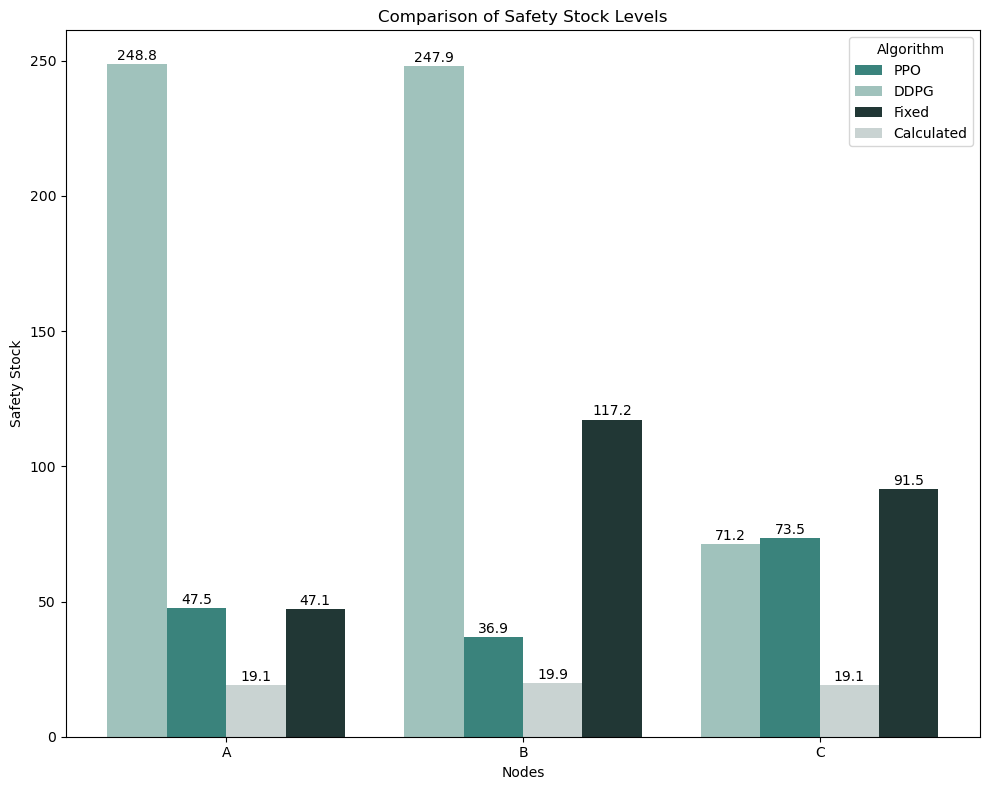

In [18]:
# Combine the safety stock data into a single DataFrame
safety_stock_df = pd.DataFrame({
    'PPO': safety_stock_ppo,
    'DDPG': safety_stock_ddpg,
    'Fixed': safety_stock_fixed,
    'Calculated': safety_stock_heuristic
}).reset_index()

# Define bar width and positions
bar_width = 0.2
nodes = safety_stock_df['Node']
x = np.arange(len(nodes))  # Position of nodes on x-axis

# Plot bars for each algorithm
plt.figure(figsize=(10, 8))
bars_ppo = plt.bar(x - bar_width / 2, safety_stock_df['PPO'], width=bar_width, label='PPO', color='#3A837C')
bars_ddpg = plt.bar(x - bar_width * 1.5, safety_stock_df['DDPG'], width=bar_width, label='DDPG', color='#A0C2BC')
bars_fixed = plt.bar(x + bar_width * 1.5, safety_stock_df['Fixed'], width=bar_width, label='Fixed', color='#213735')
bars_heuristic = plt.bar(x + bar_width * 0.5, safety_stock_df['Calculated'], width=bar_width, label='Calculated', color='#C9D3D2')

# #000000 for black
colors = ["#3A837C", "#A0C2BC", "#C9D3D2", "#213735", "cyan"]

# Annotate the bars with safety stock values
for bars in [bars_ppo, bars_ddpg, bars_fixed, bars_heuristic]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.5, 
            f'{height:.1f}', 
            ha='center', 
            va='bottom'
        )

# Customize the plot
plt.xlabel('Nodes')
plt.ylabel('Safety Stock')
plt.title('Comparison of Safety Stock Levels')
plt.xticks(x, nodes)  # Set node labels on the x-axis
plt.legend(title='Algorithm')
plt.tight_layout()

# Show the plot
plt.show()

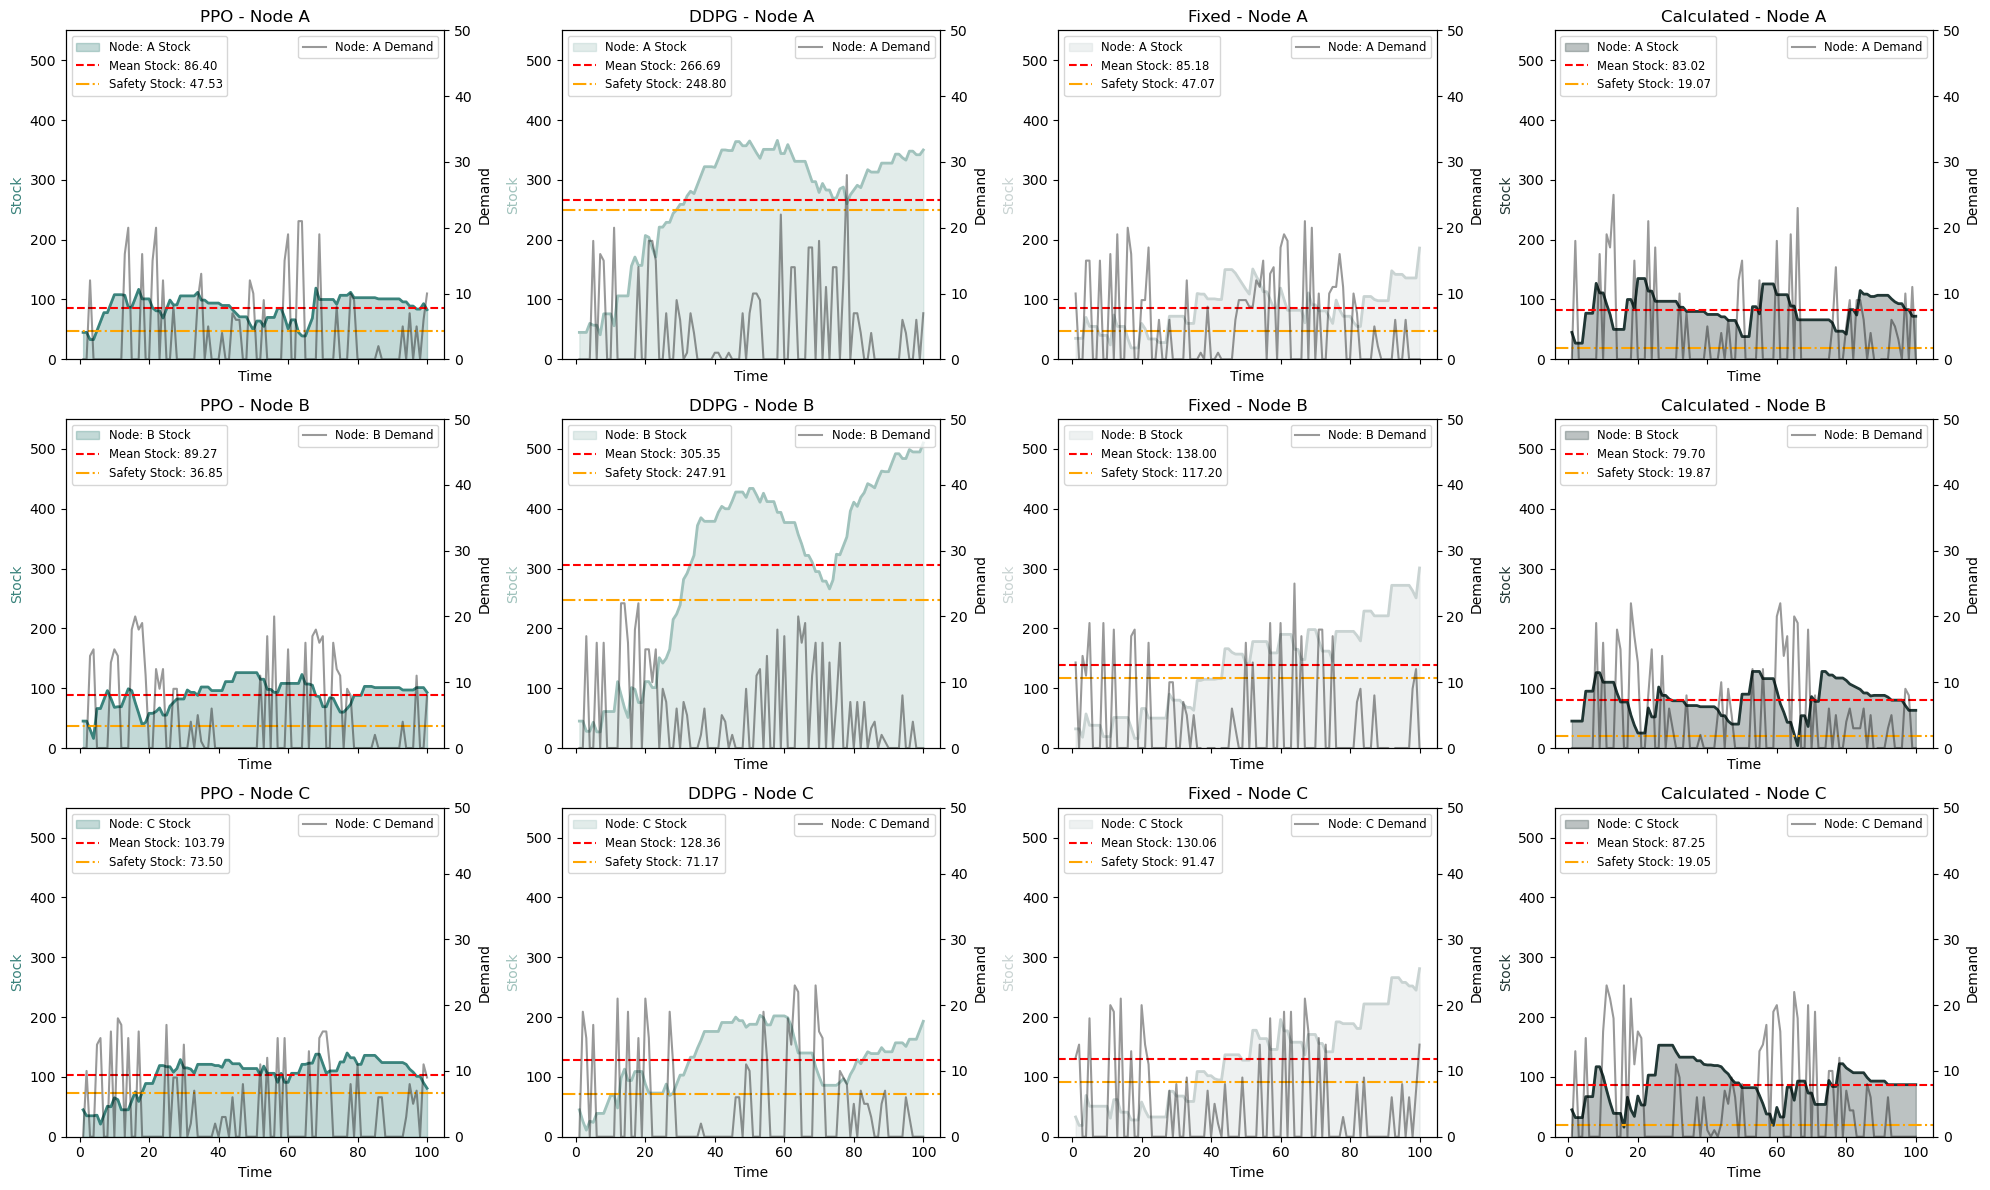

In [19]:
# Define the algorithms and their respective dataframes
algorithms = {
    "PPO": df_ppo,
    "DDPG": df_ddpg,
    "Fixed": df_fixed,
    "Calculated": df_heuristic
}

# Define safety stock values for each algorithm
safety_stocks = {
    "PPO": safety_stock_ppo,
    "DDPG": safety_stock_ddpg,
    "Fixed": safety_stock_fixed,
    "Calculated": safety_stock_heuristic
}

# Define colors for the algorithms
colors = ["#3A837C", "#A0C2BC", "#C9D3D2", "#213735"]

# Create subplots for the nodes
unique_nodes = df_ppo["Node"].unique()  # Assuming all dataframes share the same nodes
fig, axs = plt.subplots(len(unique_nodes), len(algorithms), figsize=(20, len(unique_nodes) * 4), sharex=True)

# Loop over all nodes
for i, node in enumerate(unique_nodes):
    # Loop over algorithms
    for j, (algo_name, algo_df) in enumerate(algorithms.items()):
        # Select the data for this node
        node_data = algo_df[algo_df["Node"] == node]

        # Create a secondary y-axis for demand
        ax_stock = axs[i, j]
        ax_demand = ax_stock.twinx()

        # Plot the 'Stock' as a filled line plot
        ax_stock.fill_between(
            node_data["Time"],
            node_data["Stock"],
            color=colors[j % len(colors)],
            alpha=0.3,
            label=f"Node: {node} Stock"
        )

        # Add a line to represent the stock more clearly
        ax_stock.plot(
            node_data["Time"],
            node_data["Stock"],
            color=colors[j % len(colors)],
            linewidth=2,
            label=None  # Avoid duplicate labels for the line
        )

        # Add the mean stock line
        mean_stock = node_data["Stock"].mean()
        ax_stock.axhline(
            mean_stock,
            color="red",
            linestyle="--",
            label=f"Mean Stock: {mean_stock:.2f}",
        )

        # Add the safety stock line using precomputed values
        safety_stock = safety_stocks[algo_name].get(node, None)
        if safety_stock is not None:
            ax_stock.axhline(
                safety_stock,
                color="orange",
                linestyle="-.",
                label=f"Safety Stock: {safety_stock:.2f}",
            )

        # Plot the 'Demand' as a line on the secondary y-axis
        ax_demand.plot(
            node_data["Time"],
            node_data["Demand"],
            label=f"Node: {node} Demand",
            color="black",
            alpha=0.4
        )

        # Customize the axes
        ax_stock.set_title(f"{algo_name} - Node {node}")
        ax_stock.set_xlabel("Time")
        ax_stock.set_ylabel("Stock", color=colors[j % len(colors)])
        ax_stock.set_ylim(0, 550)
        ax_demand.set_ylabel("Demand", color="black")
        ax_demand.set_ylim(0, 50)
        
        # Set legends
        ax_stock.legend(loc="upper left", fontsize="small")
        ax_demand.legend(loc="upper right", fontsize="small")

# Adjust layout
plt.tight_layout()
plt.show()